# Long / Short at 9h00 prediction

### Import Library

In [220]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [221]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [222]:
data = dataset.copy()

In [223]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2018-08-13 09:00:00,943.5,943.6,942.9,943.1,1812
2018-08-13 09:05:00,943.1,943.5,942.9,943.3,1323
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,1207
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,1196
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765
...,...,...,...,...,...
2025-02-14 14:15:00,1343.0,1343.0,1340.3,1341.3,7141
2025-02-14 14:20:00,1340.9,1341.9,1340.5,1341.4,4593
2025-02-14 14:25:00,1341.1,1342.5,1340.7,1342.5,4207


In [224]:
data['RSI'] = ta.rsi(data["Close"], length=25)

## Prepare labels

In [225]:
daily_data = data.resample('D').agg({
        'Volume': 'sum',
        'Open': 'first',
        'Close': 'last',
        'High': 'max',
        'Low': 'min',
        'RSI': 'last'
    })
daily_data.dropna(subset=['Close'], inplace=True)
daily_data["stoploss"] = daily_data.apply(lambda r: max(r["Open"] * 0.322 / 100, 3), axis=1)
daily_data["LS_able_900"] = daily_data.apply(lambda r: False if (r["High"] > r["Open"] + r["stoploss"] and r["Low"] < r["Open"] - r["stoploss"]) else True , axis=1)
daily_data["Deal"] = daily_data.apply(lambda r: None if r["LS_able_900"] == False else ("Short" if r["Low"] < r["Open"] - r["stoploss"] else "Long"), axis=1)
daily_data["Deal_Int"] = daily_data.apply(lambda r: 0 if r["Deal"] == None else (1 if r["Deal"] == "Long" else 2), axis=1)
daily_data["return"] = daily_data.apply(lambda r: 0 if r["Deal"] == None else (r["Close"] - r["Open"] if r["Deal"] == "Long" else r["Open"] - r["Close"]), axis=1)

## Tính Volume Profile theo ngày

In [226]:
def volume_profile(df):
    low_price = df["Low"].min()
    high_price = df["High"].max()
    n_bins = 24
    
    # --- Tạo bins ---
    bins = np.linspace(low_price, high_price, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    volume_profile = pd.Series(0.0, index=bin_centers)
    
    # --- Phân bổ volume vào bins ---
    for _, row in df.iterrows():
        # các giá nằm trong khoảng nến
        mask = (bin_centers >= row["Low"]) & (bin_centers <= row["High"])
        count = mask.sum()
        if count > 0:
            vol_per_bin = row["Volume"] / count
            volume_profile.loc[mask] += vol_per_bin

    return volume_profile

def cal_poc(vp):
    poc_price = vp.idxmax()
    return poc_price

In [227]:
%%time
daily_data["POC"] = 0
for i, row in daily_data.iterrows():
    current_date = row.name.strftime('%Y-%m-%d ').format()
    # Tạo khoảng thời gian trong ngày
    start_time = pd.Timestamp(current_date + " 08:00:00")
    end_time   = pd.Timestamp(current_date + " 15:00:00")
    
    # Lọc dữ liệu 5m của ngày đó
    tmp_df = data[(data.index >= start_time) & (data.index <= end_time)]
    tmp_vp = volume_profile(tmp_df)
    poc = cal_poc(tmp_vp)
    daily_data.loc[i, 'POC'] = poc

CPU times: user 28.1 s, sys: 5.16 ms, total: 28.1 s
Wall time: 28.2 s


In [228]:
daily_data

,Volume,Open,Close,High,Low,RSI,stoploss,LS_able_900,Deal,Deal_Int,return,POC
Date,,,,,,,,,,,,
2018-08-13,79327,943.5,954.2,954.6,942.3,74.598880,3.038070,True,Long,1,10.7,943.068750
2018-08-14,79266,955.5,959.3,961.8,952.1,61.041527,3.076710,False,None,0,0.0,955.939583
2018-08-15,89449,958.0,946.6,962.3,946.6,30.475502,3.084760,False,None,0,0.0,958.047917
2018-08-16,71410,942.4,947.0,947.3,935.5,57.919290,3.034528,False,None,0,0.0,941.645833
2018-08-17,98531,952.2,947.0,954.6,945.0,44.311240,3.066084,True,Short,2,5.2,953.200000
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10,185266,1333.4,1330.5,1337.6,1325.2,42.009268,4.293548,True,Short,2,2.9,1332.691667
2025-02-11,143632,1332.5,1334.1,1334.1,1327.6,57.469921,4.290650,True,Short,2,-1.6,1330.443750
2025-02-12,139180,1337.4,1329.5,1342.0,1329.5,27.606077,4.306428,False,None,0,0.0,1339.135417


In [229]:
daily_data["POC-1"] = daily_data["POC"].shift(1)
daily_data["POC-2"] = daily_data["POC"].shift(2)
daily_data["next_Open"] = daily_data["Open"].shift(-1)
daily_data["next_Deal"] = daily_data["Deal_Int"].shift(-1)
daily_data.dropna(subset=['next_Open'], inplace=True)

## AI prediction

In [230]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [231]:
daily_data["f1"] =  daily_data["High"] - daily_data["POC"]
daily_data["f2"] =  daily_data["POC"] - daily_data["Low"]
daily_data["f3"] =  daily_data["Close"] - daily_data["POC"]
daily_data["f4"] =  daily_data["next_Open"] - daily_data["POC"]
daily_data["f5"] =  daily_data["next_Open"] - daily_data["Close"]

In [232]:
# Define Features and Target Variable
# features = ["Open", "High", "Low", "Close", "POC", "RSI", "next_Open"]
# features = ["Open", "High", "Low", "Close", "POC", "POC-1", "POC-2", "next_Open"]
features = ["f1", "f2", "f3", "f4", "f5"]
X = daily_data
y = daily_data["next_Deal"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[features]
X_test2 = X_test[features]

In [233]:
# Train Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [234]:
# Predictions
y_pred = model.predict(X_test2)

In [235]:
# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.38461538461538464
              precision    recall  f1-score   support

         0.0       0.45      0.38      0.41        99
         1.0       0.43      0.40      0.41       130
         2.0       0.30      0.36      0.33        96

    accuracy                           0.38       325
   macro avg       0.39      0.38      0.38       325
weighted avg       0.39      0.38      0.39       325



In [236]:
y_test

Date
2019-03-01    1.0
2021-12-28    1.0
2023-07-25    1.0
2023-06-28    2.0
2021-02-23    0.0
             ... 
2020-10-29    0.0
2019-10-07    1.0
2020-04-21    0.0
2023-11-02    2.0
2021-06-17    1.0
Name: next_Deal, Length: 325, dtype: float64

In [237]:
import xgboost as xgb
from sklearn import metrics
from xgboost import plot_importance

In [238]:
# Create XGBClassifier model
model_xgb = xgb.XGBClassifier(n_estimators=100, random_state=42)

# Train XGBClassifier
model_xgb = model_xgb.fit(X_train, y_train)

# Predict the response for test dataset
y2_pred = model_xgb.predict(X_test2)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y2_pred))

Accuracy: 0.4276923076923077


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

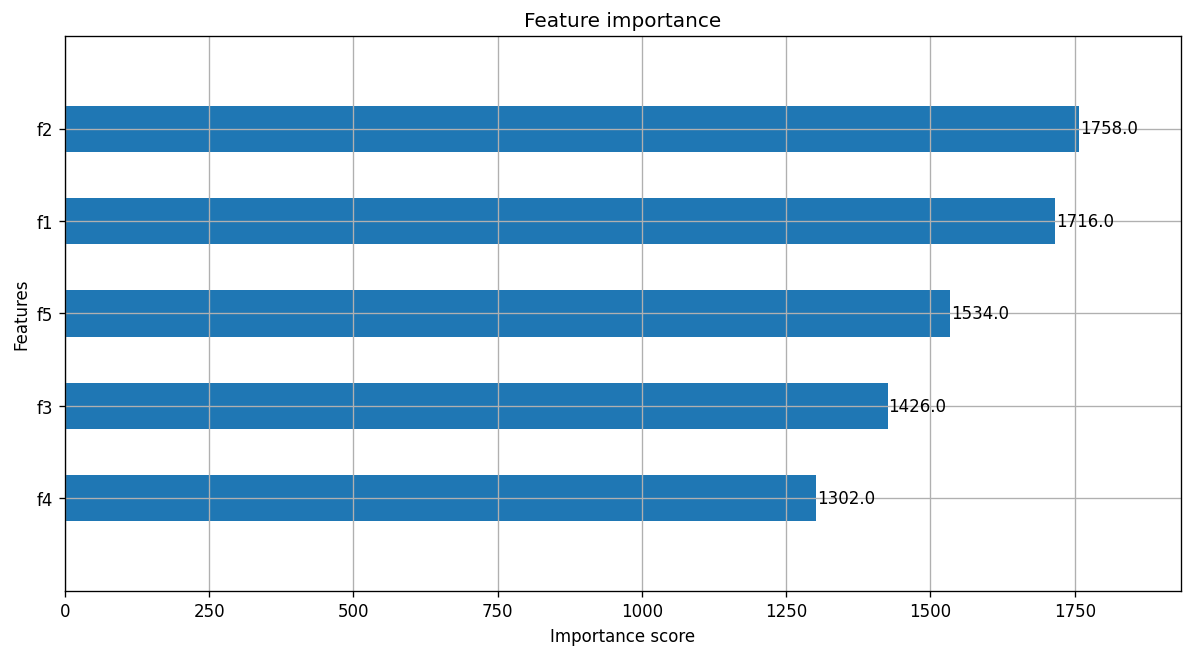

In [239]:
plot_importance(model_xgb, max_num_features=20, height=0.5)

In [240]:
X_test["deal"] = y_test
X_test["pred"] = y2_pred
X_test["profit"] = X_test.apply(lambda r: 0 if r["pred"] == 0 else ( r["return"] if r["deal"] == r["pred"] else -r["stoploss"]), axis=1)

In [241]:
X_test["profit"].sum()

np.float64(-84.42195000000046)

In [242]:
len(X_test["profit"])

325